
<br>
The following script has 4 main sections.<br>
We first calculate the optimal investment weights of a trading strategy<br>
by optimization. Then, we calculate the in and out of sample returns<br>
for the strategy and the chosen benchmark.<br>
Ultimately, we calculate performance and risk ratios and plot portfolio<br>
characteristics of the investment strategy in comparison to the benchmark.<br>


load libraries

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from scipy.optimize import minimize
from scipy.optimize import Bounds
from sklearn.linear_model import LinearRegression
import dataframe_image as dfi

###########################################################################<br>
                                                                          #<br>
                               #SECTION 1                                 #<br>
      Define key parameters, import needed files and define investment    #<br>
      universe of stocks which the strategy invests in                    #<br>
                                                                          #<br>
###########################################################################

define parameters of investment period start (start_backtesting as maximum time period!)<br>
actual time could be shorter depending on availability of data!

In [13]:
start_backtesting = np.datetime64("2011-01-01")
end_backtesting = np.datetime64("2021-12-31")
end_out_sample = np.datetime64("2022-05-21")

Import needed CSV files

In [14]:
stocks_index = pd.read_csv("../files/index_constituents_data.csv", index_col=0)
benchmark = pd.read_csv("../files/benchmark.csv", index_col=0)
Gross_Price = pd.read_csv("../files/Gross_Prices_EUR.csv", index_col=0)
Net_Price = pd.read_csv("../files/Net_Prices_EUR.csv", index_col=0)

format index to date

In [15]:
Gross_Price.index = pd.to_datetime(Gross_Price.index)
Net_Price.index = pd.to_datetime(Net_Price.index)
benchmark.index = pd.to_datetime(benchmark.index)


<br>
Select stocks which the strategy invests in<br>
our strategy goes long in the top 10 highest dividend stocks and short in the<br>
top 10 lowest dividend stocks --> We select these stocks as our investmnet stocks<br>
Also: drop BHP stock for which dividends have not been calculated correctly!<br>


In [16]:
stocks_index = stocks_index.sort_values(by="Yield", ascending=False)
stocks_index = stocks_index.drop("BHP.L")
stocks_invest = stocks_index.iloc[np.r_[0:10, 39:49]]

select prices of stocks which we invest in

In [17]:
Gross_Price_selected = Gross_Price[stocks_invest.index]
Net_Price_selected = Net_Price[stocks_invest.index]

###########################################################################<br>
                                                                          #<br>
                               #SECTION 2                                 #<br>
    Calculate Optimal Strategy stock weights with various constraints     #<br>
                      and visualize optimization                          #<br>
                                                                          #<br>
###########################################################################

estimate expected returns and var-cov matrix for optimization (with in sample data!)

In [18]:
rf_daily = 0
ER = Gross_Price_selected[Gross_Price_selected.index < end_backtesting].pct_change().mean()
S = Gross_Price_selected[Gross_Price_selected.index < end_backtesting].pct_change().cov()

define functions for optimization (variance, return,  negative sharp ratio)

In [19]:
def pvar(w, S):
    return (w.T @ S @ w)

def pret(w, ER):
    return (w.T @ ER)

def sharpe(w, ER, S):
    return -(w.T @ (ER - rf_daily)) / ((w.T @ S @ w) ** 0.5)

---------------------------------------------------------------------------<br>
Calculate Optimized Portfolio<br>
---------------------------------------------------------------------------

In [20]:
N = len(ER)
x0 = np.ones(N) / N


<br>
#set up constraints<br>
first constraint -> total investment = 100% long<br>
second constraint- > Values smaller than - min_weight (shocks which are shorted)<br>
third constraint -> Values larger than min_weight (stock which are longed)<br>
bounds = maximum long and short % for stocks<br>


In [21]:
min_weight = 0.02
cons_multiple = ({"type": "eq", "fun": lambda x: np.sum(x) - 1},
                 {"type": "ineq", "fun": lambda x: -min_weight - x[10:20]},
                 {"type": "ineq", "fun": lambda x: x[0:10] - min_weight})
bounds = Bounds(-0.2, 0.2)

only constraint for unconstrained portfolio --> Total stock weights == 100%

In [22]:
cons_simple = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})

calculate optimized values (GMVP and MSRP constrained and unconstrained)

In [23]:
GMVP_const = minimize(pvar, x0, method='SLSQP', args=S, constraints=cons_multiple,
                      options={'disp': True, 'ftol': 1e-9}, bounds=bounds)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00018520068752565962
            Iterations: 36
            Function evaluations: 756
            Gradient evaluations: 36


In [24]:
GMVP_unconst = minimize(pvar, x0, method="SLSQP", args=S, constraints=cons_simple,
                        options={'disp': True, 'ftol': 1e-9})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00011595972625592764
            Iterations: 24
            Function evaluations: 504
            Gradient evaluations: 24


In [25]:
MSRP_const = minimize(sharpe, x0, method='SLSQP', args=(ER, S), constraints=cons_multiple,
                      options={'disp': True, 'ftol': 1e-9}, bounds=bounds)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.07287612274278345
            Iterations: 16
            Function evaluations: 336
            Gradient evaluations: 16


In [26]:
MSRP_unconst = minimize(sharpe, x0, method='SLSQP', args=(ER, S), constraints=cons_simple,
                        options={'disp': True, 'ftol': 1e-9})

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.18343376648116225
            Iterations: 34
            Function evaluations: 717
            Gradient evaluations: 34


complete data set of selected stocks with calculated constrained MSRP values & export for presentation

In [27]:
stocks_invest = stocks_invest.assign(weights=MSRP_const.x)
stocks_invest = stocks_invest.assign(weights_unconst=MSRP_unconst.x)
stocks_invest_export = stocks_invest.copy()
stocks_invest_export["Yield"] = stocks_invest_export["Yield"].map('{:,.2%}'.format)
stocks_invest_export["weights"] = stocks_invest_export["weights"].map('{:,.2%}'.format)
stocks_invest_export["index_weights"] = stocks_invest_export["index_weights"].map('{:,.2%}'.format)
stocks_invest_export["weights_unconst"] = stocks_invest_export["weights_unconst"].map('{:,.2%}'.format)

In [28]:
dfi.export(stocks_invest_export, "../plots/selected_portfolio_characteristics.png")

---------------------------------------------------------------------------<br>
Visualize efficient Frontier<br>
---------------------------------------------------------------------------


<br>
Generate Minimum Variance Frontier / Investment Frontier plot by doing the following: <br>
1. Minimize the negative value of the expected portfolio return <br>
given a deterministic variance and the same rules as above (eg. min 2% in each stock)<br>
as restrictions in the optimization. --> We thus retrieve the maximum return given <br>
all restrictions for a given variance. <br>
2. We construct "random portfolios" which fulfill all the restrictions by minimizing a function<br>
which consists of a random array and a modulus operation which should randomize the optimization <br>
results. We can then calculate the expected return and variance of these portfolios and add them <br>
to the plot.<br>


calculate yearly volatility and expected return of GMVP and MSRP constrained for plotting further below<br>
assumption: year = 250 trading days

In [29]:
GMVP_const_ER = pret(w=GMVP_const.x, ER=ER) * 250
GMVP_const_VAR = m.sqrt(pvar(w=GMVP_const.x, S=S) * 250)
MSRP_const_ER = pret(w=MSRP_const.x, ER=ER) * 250
MSRP_const_VAR = m.sqrt(pvar(w=MSRP_const.x, S=S) * 250)

define negative portfolio return function

In [30]:
def pret_sim(w, ER):
    return -(w.T @ ER)

variances to loop over

In [31]:
var_list = np.arange(0.1, 0.6, 0.01)
bounds = Bounds(-0.2, 0.2)

initialize lists to store results in

In [32]:
MVF_var_const = []
MVF_ret_const = []

loop over variances and maximize expected return given that portfolio variance = given variance

In [33]:
for i in var_list:
    max_var = i
    cons = ({"type": "eq", "fun": lambda x: np.sum(x) - 1},
            {"type": "eq", "fun": lambda x: m.sqrt((x.T @ S @ x) * 250) - max_var},
            {"type": "ineq", "fun": lambda x: -min_weight - x[10:20]},
            {"type": "ineq", "fun": lambda x: x[0:10] - min_weight})
    maximized = minimize(pret_sim, x0, method='SLSQP', args=ER,
                         options={'disp': True, 'ftol': 1e-9},
                         constraints=cons, bounds=bounds)

    # only store result if optimization was successful!
    if maximized.success:
        MVF_var_const.append(i)
        MVF_ret_const.append(maximized.fun * -250)
    else:
        continue

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.0006394837591515637
            Iterations: 50
            Function evaluations: 1052
            Gradient evaluations: 46
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.0006349282283740886
            Iterations: 54
            Function evaluations: 1119
            Gradient evaluations: 50


C:\Users\sveng\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.0006331299418609069
            Iterations: 66
            Function evaluations: 1630
            Gradient evaluations: 62
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.0006331299486566867
            Iterations: 77
            Function evaluations: 1584
            Gradient evaluations: 73
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.0006331299341356747
            Iterations: 49
            Function evaluations: 1145
            Gradient evaluations: 45
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.0006331299296138406
            Iterations: 49
            Function evaluations: 1134
            Gradient evaluations: 45
Positive directional derivative for linesearch    (Exit mode 8)
            Current function val

Iteration limit reached    (Exit mode 9)
            Current function value: -0.00010533040092795603
            Iterations: 100
            Function evaluations: 2882
            Gradient evaluations: 98
Iteration limit reached    (Exit mode 9)
            Current function value: -0.0001050456217045082
            Iterations: 100
            Function evaluations: 2807
            Gradient evaluations: 97
Iteration limit reached    (Exit mode 9)
            Current function value: -0.00010477865696608367
            Iterations: 100
            Function evaluations: 2947
            Gradient evaluations: 100
Iteration limit reached    (Exit mode 9)
            Current function value: -0.00010452779389703414
            Iterations: 100
            Function evaluations: 2884
            Gradient evaluations: 98
Iteration limit reached    (Exit mode 9)
            Current function value: -0.00010429155315784251
            Iterations: 100
            Function evaluations: 2845
            

---------------------------------------------------------------------------<br>
Visualize efficient Frontier<br>
---------------------------------------------------------------------------

In [34]:
random_portfolio = []

"random" function which when optimized gives "random" portfolios

In [35]:
def rand_funct(x, y):
    return ((x % y) / y).sum()

weight constraints of individual stocks

In [36]:
cons = ({"type": "eq", "fun": lambda x: np.sum(x) - 1},
        {"type": "ineq", "fun": lambda x: -min_weight - x[10:20]},
        {"type": "ineq", "fun": lambda x: x[0:10] - min_weight})

simulate 100 different portfolios which fulfill the constraints

In [ ]:
i = 0
np.random.seed(0)

while i < 100:
    y = np.random.uniform(low=0, high=1, size=N)
    portfolio_sim = minimize(rand_funct, x0, method='SLSQP', args=y,
                             constraints=cons, options={'disp': True, 'ftol': 1e-9},
                             bounds=bounds)
    i = i + 1

    # only store successful optimizations
    if portfolio_sim.success:
        random_portfolio.append(portfolio_sim.x)
    else:
        continue

MVF_randvar_const = []
MVF_randret_const = []

calculate return and variance (yearly) from calculated "random" portfolios

In [ ]:
for i in range(len(random_portfolio)):
    exp_return = pret(w=random_portfolio[i], ER=ER)
    exp_var = pvar(w=random_portfolio[i], S=S)
    exp_return_year = exp_return * 250
    exp_var_year = m.sqrt(exp_var * 250)
    MVF_randvar_const.append(exp_var_year)
    MVF_randret_const.append(exp_return_year)

plot results

In [ ]:
MVF_var_const.insert(0, GMVP_const_VAR)
MVF_ret_const.insert(0, GMVP_const_ER)
CAL_x = np.linspace(0, MSRP_const_VAR + 0.2, 50, endpoint=True)
SR_MSRP = MSRP_const_ER / MSRP_const_VAR
CAL_y = 0 + SR_MSRP * CAL_x
frontier_points = pd.DataFrame({"variance": MVF_var_const, "return": MVF_ret_const})
max_ret_index = frontier_points["return"].idxmax()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(frontier_points.variance.iloc[0:max_ret_index + 1], frontier_points["return"].iloc[0:max_ret_index + 1])
plt.plot(frontier_points.variance.iloc[max_ret_index: len(frontier_points)],
         frontier_points["return"].iloc[max_ret_index: len(frontier_points)], color="grey", ls="--")
plt.scatter(MVF_randvar_const, MVF_randret_const)
plt.scatter(GMVP_const_VAR, GMVP_const_ER, s=70)
plt.scatter(MSRP_const_VAR, MSRP_const_ER, s=70)
plt.plot(CAL_x, CAL_y)
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])
plt.title("Investment Frontier Simulated", size=25)
plt.xlabel("Volatility", size=15)
plt.ylabel("Return", size=15)
plt.legend(["Minimum Variance Frontier",
            "Investment Frontier",
            "Capital Allocation Line",
            "random portfolios",
            "GMVP",
            "MSRP"],
           prop={'size': 15})
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("../plots/investmentfrontier.png")

###########################################################################<br>
                                                                          #<br>
                               #SECTION 2                                 #<br>
                          Calculate  returns of                           #<br>
                strategy and benchmark in and out of sample               #<br>
                                                                          #<br>
###########################################################################

function which calculates the indexed performance (start = 1) of various stocks and start investment weights

In [37]:
def indexed_performance(start, prices, weights, end=None):
    # filter desired time range
    if end is None:
        temp = prices[prices.index >= start]
    else:
        temp = prices[(prices.index >= start) & (prices.index < end)]

    # define daily percentage changes + 1
    temp = temp.pct_change() + 1

    # replace first row with weights of each stock --> Initial Investment = 1
    temp.iloc[0] = weights

    # take cumulative return of each stock * initial investment (weight) and sum up horizontaly
    temp = temp.cumprod().sum(axis=1)
    return temp

calculate weights of short stocks / long stocks  that they sum up to 1

In [38]:
weights_short = stocks_invest.weights[stocks_invest.weights < 0] / stocks_invest.weights[stocks_invest.weights < 0].sum()
weights_long = stocks_invest.weights[stocks_invest.weights > 0] / stocks_invest.weights[stocks_invest.weights > 0].sum()

calculate the needed indexed performance series

In [39]:
in_sample_net = indexed_performance(start=start_backtesting, end=end_backtesting,
                                    weights=MSRP_const.x, prices=Net_Price_selected)

in_sample_gross = indexed_performance(start=start_backtesting, end=end_backtesting,
                                      weights=MSRP_const.x, prices=Gross_Price_selected)

out_sample_gross_short = indexed_performance(start=end_backtesting, weights=weights_short,
                                             prices=Gross_Price_selected[
                                                 stocks_invest[stocks_invest.weights < 0].index])

out_sample_gross_long = indexed_performance(start=end_backtesting, weights=weights_long,
                                            prices=Gross_Price_selected[stocks_invest[stocks_invest.weights > 0].index])

out_sample_gross = indexed_performance(start=end_backtesting, weights=MSRP_const.x,
                                       prices=Gross_Price_selected)

combine all returns to data frame (one for in and one for out of sample performance)

In [40]:
in_sample = pd.DataFrame({"strategy_net": in_sample_net,
                          "strategy_gross": in_sample_gross},
                         index=in_sample_net.index)

In [41]:
out_sample = pd.DataFrame({"strategy_gross": out_sample_gross,
                           "long_gross": out_sample_gross_long,
                           "short_gross": out_sample_gross_short},
                          index=out_sample_gross.index)

join benchmark data & calculate indexed performance of benchmark

In [42]:
in_sample = in_sample.join(benchmark)
out_sample = out_sample.join(benchmark)

in_sample[["benchmark_gross", "benchmark_net"]] = in_sample[["benchmark_gross", "benchmark_net"]].div(
    in_sample[["benchmark_gross", "benchmark_net"]].head(1).iloc[0])
out_sample[["benchmark_gross", "benchmark_net"]] = out_sample[["benchmark_gross", "benchmark_net"]].div(
    out_sample[["benchmark_gross", "benchmark_net"]].head(1).iloc[0])


save in and out of sample returns

In [43]:
in_sample.to_csv("../files/in_sample.csv")
out_sample.to_csv("../files/out_sample.csv")

###########################################################################<br>
                                                                          #<br>
                           #SECTION 3                                     #<br>
       #Calculate in and out of sample risk & performance ratios          #<br>
                                                                          #<br>
###########################################################################

---------------------------------------------------------------------------<br>
Annualized Sharp Ratio<br>
---------------------------------------------------------------------------

days = days per year (assumed 250 here)<br>
rf_rate = annualized risk free rate<br>
prices for which ratio should be alculated

In [44]:
def sharp_ratio(price, days, rf_rate):
    ER = price.pct_change().mean()
    SD = price.pct_change().std()
    SR = (ER - rf_rate / days) / SD * m.sqrt(days)
    return round(SR, 2)

---------------------------------------------------------------------------<br>
Yearly volatility<br>
---------------------------------------------------------------------------

In [45]:
def yearly_vol(price, days, pct=True):
    vol = m.sqrt(price.pct_change().var() * days)
    if pct:
        return format(vol, ".2%")
    else:
        return vol

---------------------------------------------------------------------------<br>
alpha and beta<br>
---------------------------------------------------------------------------

period = period of returns for which regression should be run (eg. "1Y", "1M", "1d")<br>
kwargs = optional where only alpha, beta, x or y can be returned form function (keyword = param)<br>
rf_rate = risk free rate for the "period"

In [46]:
def alpha_beta(strategy, benchmark, period, rf_period, pct=True, **kwargs):
    daily_ret_strategy = strategy.pct_change().fillna(0) + 1
    daily_ret_BM = benchmark.pct_change().fillna(0) + 1

    # calculate excess returns for the period over the risk-free rate
    period_ret_strategy = daily_ret_strategy.groupby(pd.Grouper(freq=period)).prod() - 1 - rf_period
    period_ret_BM = daily_ret_BM.groupby(pd.Grouper(freq=period)).prod() - 1 - rf_period
    model = LinearRegression().fit(period_ret_BM.to_numpy().reshape((-1, 1)),
                                   period_ret_strategy.to_numpy().reshape((-1, 1)))
    beta = model.coef_[0][0]
    if pct:
        alpha = format(model.intercept_[0], ".2%")
    else:
        alpha = model.intercept_[0]
    results = {"alpha": alpha,
               "beta": beta,
               "x": period_ret_BM.to_list(),
               "y": period_ret_strategy.to_list()}
    if len(kwargs) == 0:
        return results
    else:
        return results.get(kwargs.get("param"))

---------------------------------------------------------------------------<br>
Maximum Drawdown<br>
---------------------------------------------------------------------------

In [47]:
def maxdd(price, pct=True):
    # Value at time T divided by max value from time t = 0 to t = T (T> 0)
    diffmax = price / price.cummax()
    maxdd = (diffmax - 1).min()
    if pct:
        return format(maxdd, ".2%")
    else:
        return maxdd

---------------------------------------------------------------------------<br>
N Day unfiltered historical 1% VAR<br>
---------------------------------------------------------------------------

N as number of days (integer)

In [48]:
def NDAYVar(price, N, pct=True):
    daily_ret = price.pct_change().fillna(0) + 1
    daily_ret = daily_ret.reset_index(drop=True)
    nday_ret = daily_ret.groupby(daily_ret.index // N).prod() - 1
    VAR = nday_ret.quantile(0.01)
    if pct:
        return format(np.abs(VAR), ".2%")
    else:
        return np.abs(VAR)

---------------------------------------------------------------------------<br>
Expected N day return or total Return<br>
---------------------------------------------------------------------------

In [49]:
def nday_ret(price, N=None, TR=False, pct=True):
    if TR:
        ret = price.tail(1)[0] / price.head(1)[0] - 1
    else:
        ret = price.pct_change().mean() * N
    if pct:
        return format(ret, ".2%")
    else:
        return ret

define return series for which ratios should be calculated:

In [50]:
BM_in = in_sample["benchmark_gross"]
BM_out = out_sample["benchmark_gross"]
strategy_in = in_sample["strategy_gross"]
strategy_out = out_sample["strategy_gross"]

assemble dicts with risk return metrics

In [51]:
ratios_BM_in = {"Avg. Yearly Return": nday_ret(BM_in, N=250),
                "Avg. Yearly Sharp Ratio": sharp_ratio(BM_in, days=250, rf_rate=0),
                "Max. Drawdown": maxdd(BM_in),
                "Alpha (monthly Returns)": "0%",
                "Beta (monthly Returns)": 1,
                "Avg. Ann. Vol": yearly_vol(BM_in, days=250),
                "5d 1% Hist. VAR": NDAYVar(BM_in, N=5)}

In [52]:
ratios_BM_out = {"Return YTD": nday_ret(BM_out, TR=True),
                 "Avg. Yearly Sharp Ratio": sharp_ratio(BM_out, days=250, rf_rate=0),
                 "Max. Drawdown": maxdd(BM_out),
                 "Alpha (weekly Returns)": "0%",
                 "Beta (weekly Returns)": 1,
                 "Avg. Ann. Vol": yearly_vol(BM_out, days=250),
                 "5d 1% Hist. VAR": NDAYVar(BM_out, N=5)}

In [53]:
ratios_strategy_in = {"Avg. Yearly Return": nday_ret(strategy_in, N=250),
                      "Avg. Yearly Sharp Ratio": sharp_ratio(strategy_in, days=250, rf_rate=0),
                      "Max. Drawdown": maxdd(strategy_in),
                      "Alpha (monthly Returns)": alpha_beta(strategy_in, BM_in, "1M", rf_period=0, param="alpha"),
                      "Beta (monthly Returns)": round(alpha_beta(strategy_in, BM_in, "1M", rf_period=0, param="beta"),
                                                      2),
                      "Avg. Ann. Vol": yearly_vol(strategy_in, days=250),
                      "5d 1% Hist. VAR": NDAYVar(strategy_in, N=5)}

In [54]:
ratios_strategy_out = {"Return YTD": nday_ret(strategy_out, TR=True),
                       "Avg. Yearly Sharp Ratio": sharp_ratio(strategy_out, days=250, rf_rate=0),
                       "Max. Drawdown": maxdd(strategy_out),
                       "Alpha (weekly Returns)": alpha_beta(strategy_out, BM_out, "1W", rf_period=0, param="alpha"),
                       "Beta (weekly Returns)": round(alpha_beta(strategy_out, BM_out, "1W", rf_period=0, param="beta"),
                                                      2),
                       "Avg. Ann. Vol": yearly_vol(strategy_out, days=250),
                       "5d 1% Hist. VAR": NDAYVar(strategy_out, N=5)}

In [55]:
risk_factors_in = pd.DataFrame({"Benchmark": ratios_BM_in, "Strategy": ratios_strategy_in})
risk_factors_out = pd.DataFrame({"Benchmark": ratios_BM_out, "Strategy": ratios_strategy_out})

In [56]:
dfi.export(risk_factors_out, "../plots/risk_factors_out.png")
dfi.export(risk_factors_in, "../plots/risk_factors_in.png")

---------------------------------------------------------------------------<br>
Plot Visual Example for in Sample Alpha/ Beta Calculation<br>
---------------------------------------------------------------------------

plot regression line

In [57]:
params = alpha_beta(strategy_in, BM_in, rf_period=0, period="1M", pct=False)
x = np.arange(min(params.get("x")) - 0.1, max(params.get("x")) + 0.1, 0.01)
fitted_y = params.get("alpha") + params.get("beta") * x

assemble plot

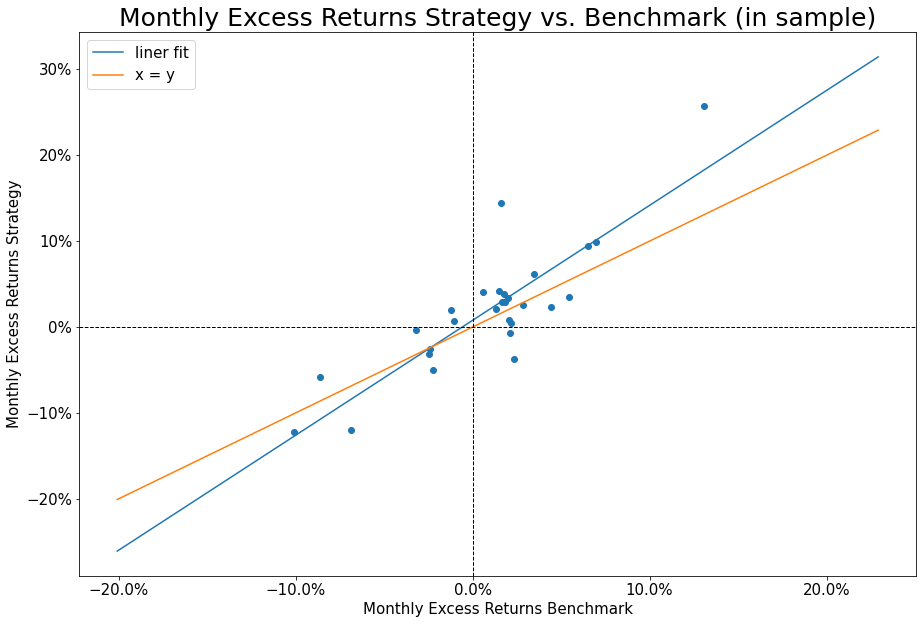

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(params.get("x"), params.get("y"))
plt.plot(x, fitted_y)
plt.plot(x, x)
plt.title("Monthly Excess Returns Strategy vs. Benchmark (in sample)", size=25)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Monthly Excess Returns Strategy", size=15)
plt.xlabel("Monthly Excess Returns Benchmark", size=15)
plt.axhline(0, color="black", ls="--", lw=1)
plt.axvline(0, color="black", ls="--", lw=1)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(["liner fit", "x = y"], prop={"size": 15})
plt.savefig("../plots/in_sample_alphabetaplot.png")

###########################################################################<br>
                                                                          #<br>
                           #SECTION 4                                     #<br>
       #Calculate and plot portfolio characteristics vs. Benchmark        #<br>
                                                                          #<br>
###########################################################################

---------------------------------------------------------------------------<br>
Excess Return Strategy vs. Benchmark Plot<br>
---------------------------------------------------------------------------

calculate return over out of sample period for all stocks in the benchmark index

In [59]:
out_sample_all = Gross_Price[Gross_Price.index > end_backtesting]
out_sample_all = out_sample_all.pct_change() + 1
out_sample_all = out_sample_all.fillna(1).cumprod()
out_return_all = out_sample_all.iloc[len(out_sample_all.index) - 1].div(out_sample_all.iloc[0]) - 1

calculate excess return contribution as (Weight Strategy - Weigh Index) * Return

In [60]:
ret_contrib = stocks_index.join(stocks_invest["weights"]).fillna(0)
ret_contrib = ret_contrib[["Name", "weights", "index_weights"]]
ret_contrib["diff_weights"] = ret_contrib["weights"] - ret_contrib["index_weights"]
ret_contrib = ret_contrib.join(pd.DataFrame(out_return_all))
ret_contrib = ret_contrib.rename(columns={0: "return"})
ret_contrib["diff_return"] = ret_contrib["diff_weights"] * ret_contrib["return"]

plot and save results

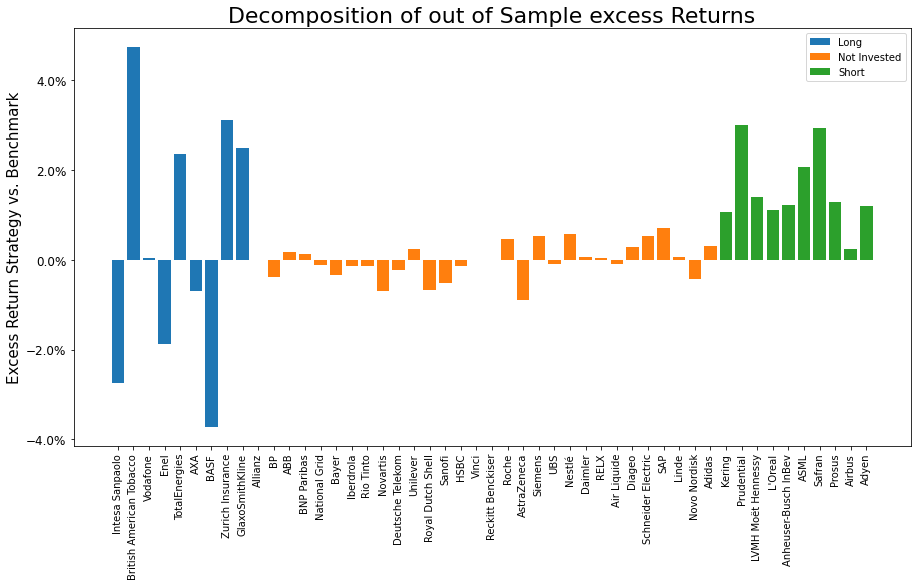

In [61]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
plt.bar(ret_contrib.Name[0:10], ret_contrib.diff_return[0:10])
plt.bar(ret_contrib.Name[10:39], ret_contrib.diff_return[10:39])
plt.bar(ret_contrib.Name[39:49], ret_contrib.diff_return[39:49])
plt.legend(["Long", "Not Invested", "Short", "Currencies"])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title("Decomposition of out of Sample excess Returns", size=22)
plt.ylabel("Excess Return Strategy vs. Benchmark", size=15)
plt.subplots_adjust(bottom=0.3)
plt.xticks(rotation=90)
plt.yticks(size=12)
plt.savefig("../plots/excess_return_breakdown.png")

---------------------------------------------------------------------------<br>
Out of Sample Gross Strategy vs Benchmark Performance<br>
---------------------------------------------------------------------------

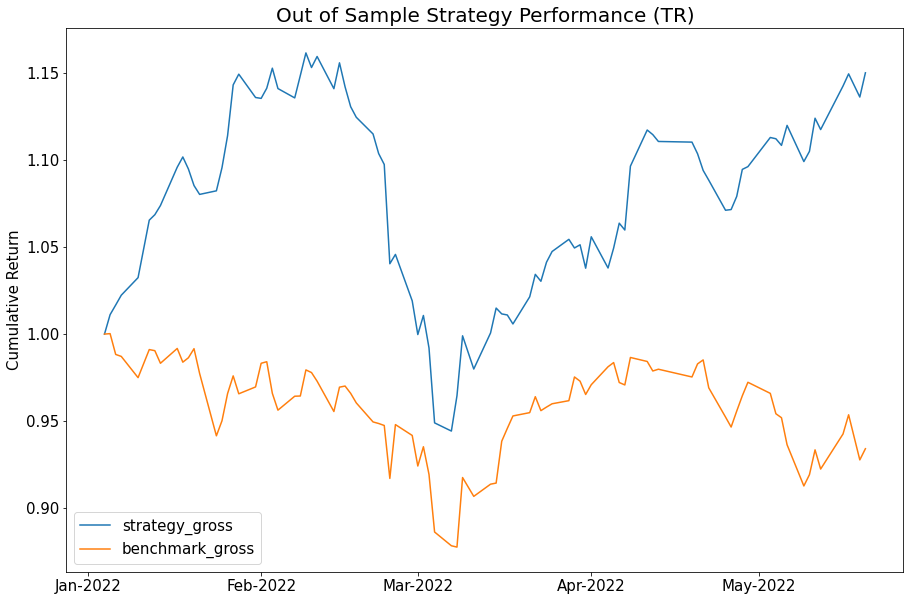

In [62]:
fig = plt.figure(figsize=(15, 10))
plt.plot(out_sample[["strategy_gross", "benchmark_gross"]])
plt.legend(out_sample[["strategy_gross", "benchmark_gross"]].columns,
           prop={"size": 15})
plt.title("Out of Sample Strategy Performance (TR)", size=20)
plt.ylabel("Cumulative Return", size=15)
plt.yticks(size=15)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(size=15)
plt.savefig("../plots/outofsample_performance.png")

---------------------------------------------------------------------------<br>
In Sample Gross Strategy vs Benchmark Performance<br>
---------------------------------------------------------------------------

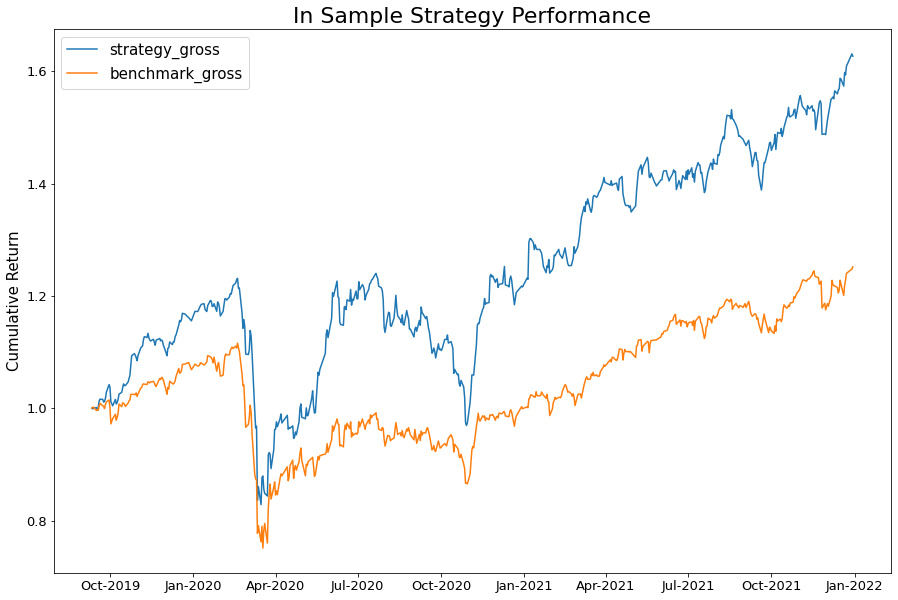

In [63]:
fig = plt.figure(figsize=(15, 10))
plt.plot(in_sample[["strategy_gross", "benchmark_gross"]])
plt.legend(in_sample[["strategy_gross", "benchmark_gross"]].columns,
           prop={"size": 15})
plt.title("In Sample Strategy Performance", size=22)
plt.ylabel("Cumulative Return", size=15)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(size=13)
plt.yticks(size=13)
plt.savefig("../plots/insample_performance.png")

---------------------------------------------------------------------------<br>
In Sample Performance Net vs. Gross<br>
---------------------------------------------------------------------------

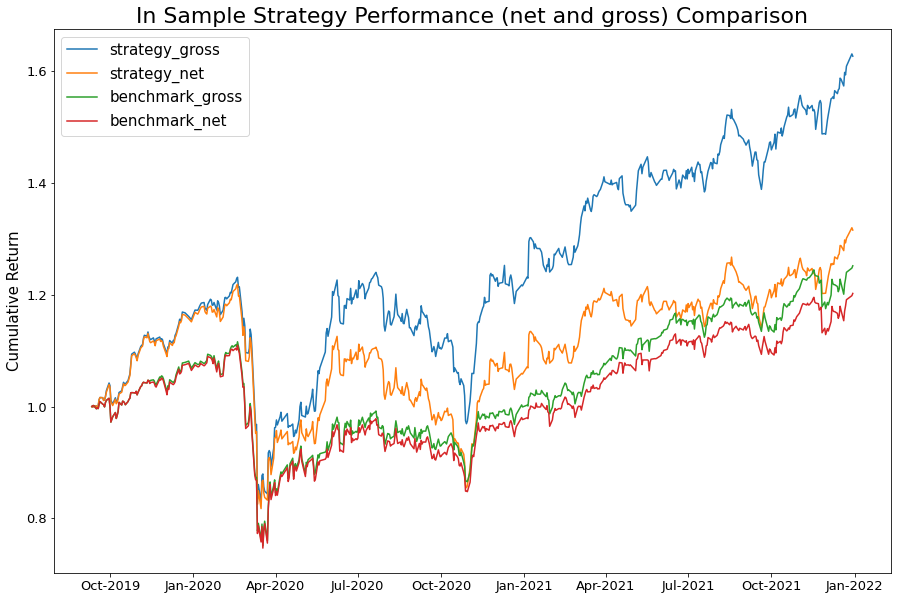

In [64]:
fig = plt.figure(figsize=(15, 10))
plt.plot(in_sample[["strategy_gross", "strategy_net", "benchmark_gross", "benchmark_net"]])
plt.legend(in_sample[["strategy_gross", "strategy_net", "benchmark_gross", "benchmark_net"]].columns,
           prop={"size": 15})
plt.title("In Sample Strategy Performance (net and gross) Comparison", size=22)
plt.ylabel("Cumulative Return", size=15)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(size=13)
plt.yticks(size=13)
plt.savefig("../plots/insample_performance_netgross.png")

---------------------------------------------------------------------------<br>
Out of Sample Performance Decomposition Long/ Short Portfolio<br>
---------------------------------------------------------------------------

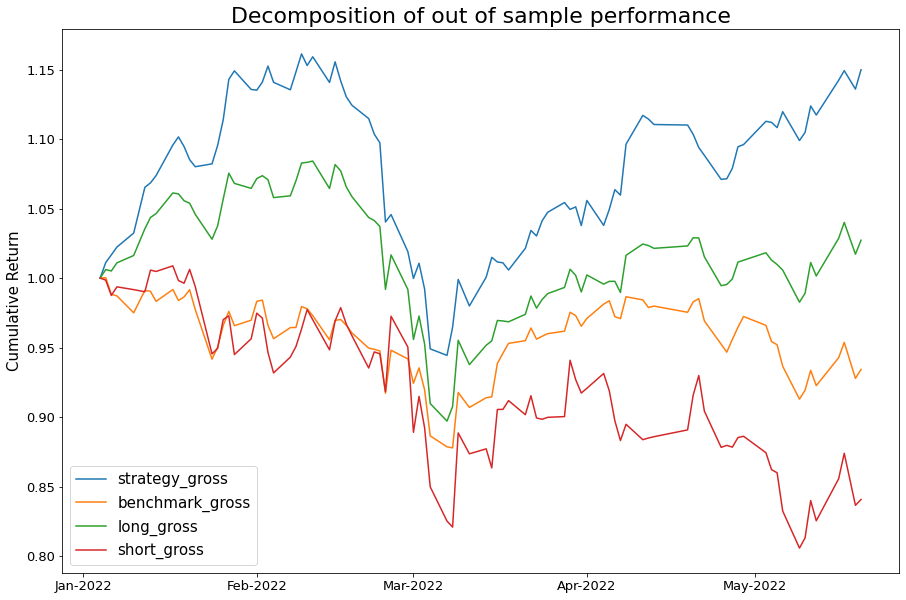

In [65]:
fig = plt.figure(figsize=(15, 10))
plt.plot(out_sample[["strategy_gross", "benchmark_gross", "long_gross", "short_gross"]])
plt.legend(out_sample[["strategy_gross", "benchmark_gross", "long_gross", "short_gross"]].columns,
           prop={"size": 15})
plt.title("Decomposition of out of sample performance", size=22)
plt.ylabel("Cumulative Return", size=15)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(size=13)
plt.yticks(size=13)
plt.savefig("../plots/outofsamlpe_brekdown.png")

---------------------------------------------------------------------------<br>
Stock Weights Index vs. Constrained & Unconstrained Optimization<br>
---------------------------------------------------------------------------

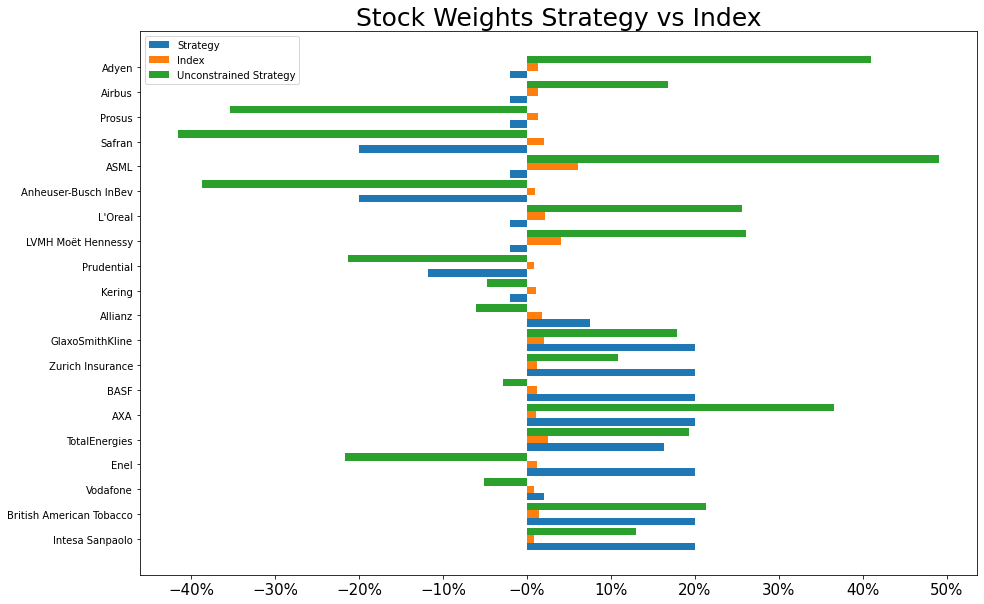

In [66]:
width = 0.3
fig, ax = plt.subplots(figsize=(15, 10))
ind = np.arange(len(stocks_invest))
ax.barh(ind, stocks_invest.weights, width, label="Strategy")
ax.barh(ind + width, stocks_invest.index_weights, width, label="Index")
ax.barh(ind + 2 * width, stocks_invest.weights_unconst, width, label="Unconstrained Strategy")
ax.set(yticks=ind + width, yticklabels=stocks_invest.Name)
ax.legend(prop={'size': 10})
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title("Stock Weights Strategy vs Index", size=25)
plt.yticks(size=10)
plt.xticks(size=15, ticks=np.arange(-0.4, 0.6, 0.1))
plt.savefig("../plots/strategy_weights.png")

---------------------------------------------------------------------------<br>
Plot Country Weights Index vs. Strategy<br>
---------------------------------------------------------------------------

In [67]:
country_weights_strategy = stocks_invest[["Country", "weights"]].groupby(by="Country").sum()
country_weights_index = stocks_index[["Country", "index_weights"]].groupby(by="Country").sum()
country_weights = country_weights_index.join(country_weights_strategy).fillna(0)
country_weights = pd.DataFrame(country_weights, index=country_weights_index.index)

assemble plot

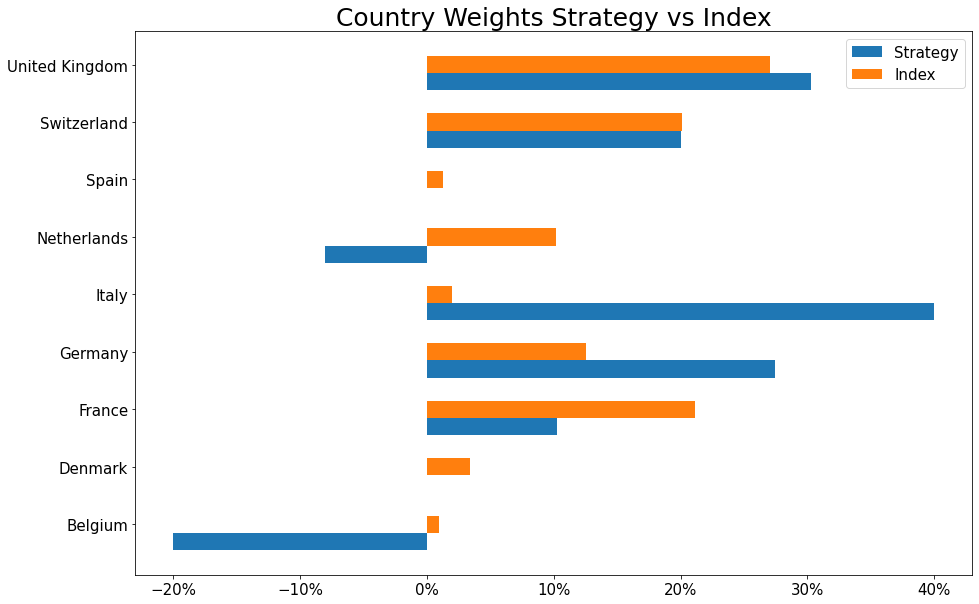

In [68]:
width = 0.3
fig, ax = plt.subplots(figsize=(15, 10))
ind = np.arange(len(country_weights))
ax.barh(ind, country_weights.weights, width, label="Strategy")
ax.barh(ind + width, country_weights.index_weights, width, label="Index")
ax.set(yticks=ind + width, yticklabels=country_weights.index)
ax.legend(prop={'size': 15})
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title("Country Weights Strategy vs Index", size=25)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig("../plots/country_weights.png")

---------------------------------------------------------------------------<br>
Plot Currency weights index vs. Strategy<br>
---------------------------------------------------------------------------

In [69]:
values = stocks_index.join(stocks_invest["weights"]).fillna(0)
currency_weights_strategy = values[["Currency", "weights"]].groupby(by="Currency").sum()
currency_weights_index = values[["Currency", "index_weights"]].groupby(by="Currency").sum()
currency_weights = currency_weights_index.join(currency_weights_strategy).fillna(0)
currency_weights = currency_weights.rename(index={"GBp": "GBP"})

assemble plot

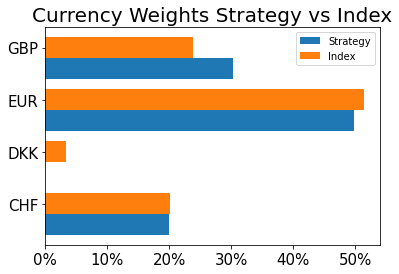

In [70]:
width = 0.4
fig, ax = plt.subplots()
ind = np.arange(len(currency_weights_index))
ax.barh(ind, currency_weights.weights, width, label="Strategy")
ax.barh(ind + width, currency_weights.index_weights, width, label="Index")
ax.set(yticks=ind + width, yticklabels=currency_weights.index)
ax.legend(["Strategy", "Index"])
plt.title("Currency Weights Strategy vs Index", size=20)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig("../plots/curency_comparison.png")

---------------------------------------------------------------------------<br>
Plot sector weights strategy vs. index<br>
---------------------------------------------------------------------------

In [71]:
sector_weights_strategy = stocks_invest[["Sector", "weights"]].groupby(by="Sector").sum()
sector_weights_index = stocks_index[["Sector", "index_weights"]].groupby(by="Sector").sum()
sector_weights = sector_weights_index.join(sector_weights_strategy)

assemble plot

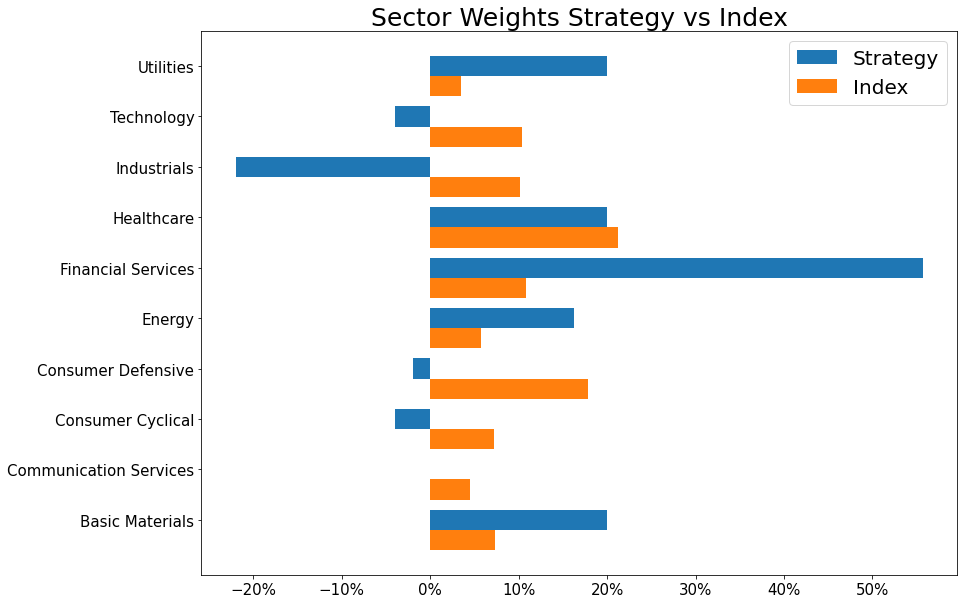

In [72]:
width = 0.4
fig, ax = plt.subplots(figsize=(15, 10))
ind = np.arange(len(sector_weights))
ax.barh(ind + width, sector_weights.weights, width, label="Strategy")
ax.barh(ind, sector_weights.index_weights, width, label="Index")
ax.set(yticks=ind + width, yticklabels=sector_weights.index)
ax.legend(prop={"size": 20})
plt.title("Sector Weights Strategy vs Index", size=25)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.yticks(size=15)
plt.xticks(size=15)
plt.subplots_adjust(left=0.2)
plt.savefig("../plots/sector_weights.png")

---------------------------------------------------------------------------<br>
Plot performance Nasdaq100 vs. MSCI World vs. FTSE AW-HighDivYield<br>
---------------------------------------------------------------------------

download prices and clean data

In [73]:
prices = yf.download(tickers=["VHYL.AS", "EXXT.DE", "IWDA.AS"], start="2022-01-01", end=end_out_sample)
prices = prices["Adj Close"]
prices = prices.div(prices.iloc[0])
prices = prices.rename(
    columns={"EXXT.DE": "Nasdaq 100", "IWDA.AS": "MSCI World", "VHYL.AS": "FTSE All World High Dividend"})

[*********************100%***********************]  3 of 3 completed


assemble plot

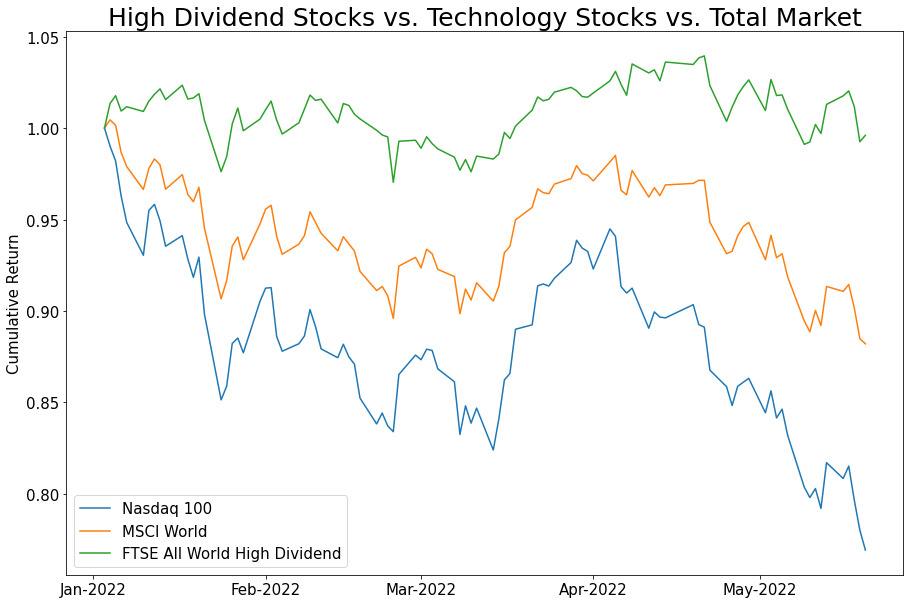

In [74]:
plt.figure(figsize=(15, 10))
plt.plot(prices)
plt.title("High Dividend Stocks vs. Technology Stocks vs. Total Market", size=25)
plt.legend(prices.columns, prop={'size': 15})
plt.ylabel("Cumulative Return", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.savefig("../plots/comparison.png")

---------------------------------------------------------------------------<br>
calculate change of correlation  matrix in vs out of sample<br>
---------------------------------------------------------------------------

In [75]:
out_sample_cor = Gross_Price_selected[Gross_Price_selected.index > end_backtesting].pct_change().corr()
in_sample_cor = Gross_Price_selected[Gross_Price_selected.index < end_backtesting].pct_change().corr()
rel_cor = out_sample_cor / in_sample_cor
pd.DataFrame(rel_cor).to_csv("../files/correlation_change.csv")

---------------------------------------------------------------------------<br>
calculate performance ratios for short and long portfolios & Benchmark<br>
---------------------------------------------------------------------------


<br>
we only include stocks which contain a forward,trailing PE ratio &<br>
PB Ratio to calculate weighted values. <br>
Further, as described by iShares,<br>
we restrict the maximum value of PE ratios to 60 and of PB ratios to 25. <br>


In [76]:
stocks_short = stocks_invest[stocks_invest.weights < 0]
stocks_long = stocks_invest[stocks_invest.weights > 0]

dividend yield

In [77]:
div_yield_long = (stocks_long.weights / stocks_long.weights.sum() * stocks_long.Yield).sum()
div_yield_short = (stocks_short.weights.abs() / stocks_short.weights.abs().sum() * stocks_short.Yield).sum()
div_yield_index = (stocks_index.index_weights / stocks_index.index_weights.sum() * stocks_index.Yield).sum()

trailing PE Ratio, forward PE, PB Ratio

get all stocks and join strategy weights

In [ ]:
index = stocks_index.join(stocks_invest[["weights"]])

1. remove stocks where ratios are not given

In [ ]:
index = index[index.Trailing_PE.notna()]
index = index[index.Forward_PE.notna()]

2. set PE ratios above 60 to 60, set PB ratios above 25 to 25

In [ ]:
index.Trailing_PE = np.where(index.Trailing_PE > 60, 60, index.Trailing_PE)
index.Forward_PE = np.where(index.Forward_PE > 60, 60, index.Forward_PE)
index.PB_Ratio = np.where(index.PB_Ratio > 25, 25, index.PB_Ratio)

3. separate long and short stocks from strategy to calculate ratios separately

In [ ]:
short = index.loc[stocks_short.index]
long = index.loc[stocks_long.index]

calculate weighted Trailing PE

In [ ]:
PE_long = (long.weights / long.weights.sum() * long.Trailing_PE).sum()
PE_short = (short.weights / short.weights.sum() * short.Trailing_PE).sum()
PE_index = (index.index_weights / index.index_weights.sum() * index.Trailing_PE).sum()

calculate weighted forward PE

In [ ]:
PE_fwd_long = (long.weights / long.weights.sum() * long.Forward_PE).sum()
PE_fwd_short = (short.weights / short.weights.sum() * short.Forward_PE).sum()
PE_fwd_index = (index.index_weights / index.index_weights.sum() * index.Forward_PE).sum()

calculate PB Ratio

In [ ]:
PB_long = (long.weights / long.weights.sum() * long.PB_Ratio).sum()
PB_short = (short.weights / short.weights.sum() * short.PB_Ratio).sum()
PB_index = (index.index_weights / index.index_weights.sum() * index.PB_Ratio).sum()

assemble metrics dataframe

In [ ]:
ratios_short = {"Yield": format(div_yield_short, ".2%"),
                "Price_Book": round(PB_short, 2),
                "Trailing_PE": round(PE_short, 2),
                "Forward_PE": round(PE_fwd_short, 2)}

In [ ]:
ratios_long = {"Yield": format(div_yield_long, ".2%"),
               "Price_Book": round(PB_long, 2),
               "Trailing_PE": round(PE_long, 2),
               "Forward_PE": round(PE_fwd_long, 2)}

In [ ]:
ratios_index = {"Yield": format(div_yield_index, ".2%"),
                "Price_Book": round(PB_index, 2),
                "Trailing_PE": round(PE_index, 2),
                "Forward_PE": round(PE_fwd_index, 2)}

In [ ]:
ratios_table = pd.DataFrame({"Portfolio Short": ratios_short, "Portfolio Long": ratios_long, "Index": ratios_index})

export table

In [ ]:
dfi.export(ratios_table, "../plots/portfolio_characteristics.png")